# Colab JAX TPU Setup

In [1]:
# Grab newest JAX version.
!pip install --upgrade -q jax==0.1.51 jaxlib==0.1.33

# Make sure the Colab Runtime is set to Accelerator: TPU.
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# The following is required to use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

     |████████████████████████████████| 235kB 3.3MB/s 
     |████████████████████████████████| 43.1MB 51kB/s 
grpc://10.118.79.162:8470


# Pmap CookBook

This notebook is an introduction to writing single-program multiple-data (SPMD) programs in JAX, and executing them synchronously in parallel on multiple devices, such as multiple GPUs or multiple TPU cores. The SPMD model is useful for computations like training neural networks with synchronous gradient descent algorithms, and can be used for data-parallel as well as model-parallel computations.

To run this notebook with any parallelism, you'll need multiple XLA devices available, e.g. with a multi-GPU machine or a Cloud TPU.

The code in this notebook is simple. For an example of how to use these tools to do data-parallel neural network training, check out [the SPMD MNIST example](https://github.com/google/jax/blob/master/examples/spmd_mnist_classifier_fromscratch.py) or the much more capable [Trax library](https://github.com/tensorflow/trax/).

In [0]:
import jax.numpy as np

## Basics

### Pure maps, with no communication

A basic starting point is expressing parallel maps with [`pmap`](https://jax.readthedocs.io/en/latest/jax.html#jax.pmap):

In [0]:
from jax import pmap

In [4]:
result = pmap(lambda x: x ** 2)(np.arange(7))
print(result)

[ 0  1  4  9 16 25 36]


In terms of what values are computed, `pmap` is similar to `vmap` in that it transforms a function to map over an array axis:

In [5]:
from jax import vmap

x = np.array([1., 2., 3.])
y = np.array([2., 4., 6.])

print(vmap(np.add)(x, y))
print(pmap(np.add)(x, y))

[3. 6. 9.]
[3. 6. 9.]


But `pmap` and `vmap` differ in in how those values are computed: where `vmap` vectorizes a function by adding a batch dimension to every primitive operation in the function (e.g. turning matrix-vector multiplies into matrix-matrix multiplies), `pmap` instead replicates the function and executes each replica on its own XLA device in parallel.

In [6]:
from jax import make_jaxpr

def f(x, y):
  a = np.dot(x, y)
  b = np.tanh(a)
  return b

xs = np.ones((8, 2, 3))
ys = np.ones((8, 3, 4))

print("f jaxpr")
print(make_jaxpr(f)(xs[0], ys[0]))

print("vmap(f) jaxpr")
print(make_jaxpr(vmap(f))(xs, ys))

print("pmap(f) jaxpr")
print(make_jaxpr(pmap(f))(xs, ys))

f jaxpr
{ lambda  ;  ; a b.
  let c = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] a b
      d = tanh c
  in [d] }

vmap(f) jaxpr
{ lambda  ;  ; a b.
  let c = dot_general[ dimension_numbers=(((2,), (1,)), ((0,), (0,)))
                       precision=None ] a b
      d = tanh c
  in [d] }

pmap(f) jaxpr
{ lambda  ;  ; a b.
  let c = xla_pmap[ axis_name=<axis 0x7f2475d5e950>
                    axis_size=8
                    devices=None
                    backend=None ] a b
        { lambda  ;  ; a b.
          let c = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                               precision=None ] a b
              d = tanh c
          in [d] } [  ;  ]
  in [c] }



Notice that applying `vmap(f)` to these arguments leads to a `dot_general` to express the batch matrix multiplication in a single primitive, while applying `pmap(f)` instead leads to a primitive that calls replicas of the original `f` in parallel.

There are also important constraints with using `pmap`:
1. `pmap` always maps over the leading axis of all of its arguments (while with `vmap` you can use `in_axes` to specify which axes get mapped),
2. with `pmap` the mapped axis size must be less than or equal to the number of XLA devices available (and for nested `pmap` functions, the product of the mapped axis sizes must be less than or equal to the number of XLA devices).

You can use the output of a `pmap` function just like any other value:

In [7]:
y = pmap(lambda x: x ** 2)(np.arange(8))
z = y / 2
print(z)

[ 0.   0.5  2.   4.5  8.  12.5 18.  24.5]


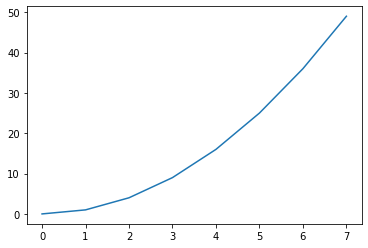

In [8]:
import matplotlib.pyplot as plt
plt.plot(y)

But while the output here acts just like a NumPy ndarray, if you look closely it has a different type:

In [9]:
y

ShardedDeviceArray([ 0,  1,  4,  9, 16, 25, 36, 49], dtype=int32)

A `ShardedDeviceArray` is effectively an `ndarray` subclass, but it's stored in pieces spread across the memory of multiple devices. Results from `pmap` functions are left sharded in device memory so that they can be operated on by subsequent `pmap` functions without moving data around, at least in some cases. But these results logically appear just like a single array.

When you call a non-`pmap` function on a `ShardedDeviceArray`, like a standard `jax.numpy` function, communication happens behind the scenes to bring the values to one device (or back to the host in the case of the matplotlib function above):

In [10]:
y / 2

DeviceArray([ 0. ,  0.5,  2. ,  4.5,  8. , 12.5, 18. , 24.5], dtype=float32)

In [11]:
import numpy as onp
onp.sin(y)

array([ 0.        ,  0.84147098, -0.7568025 ,  0.41211849, -0.28790332,
       -0.13235175, -0.99177885, -0.95375265])

Thinking about device memory is important to maximize performance by avoiding data transfers, but you can always fall back to treating arraylike values as (read-only) NumPy ndarrays and your code will still work.

Here's another example of a pure map which makes better use of our multiple-accelerator resources. We can generate several large random matrices in parallel, then perform parallel batch matrix multiplication without any cross-device movement of the large matrix data:

In [12]:
from jax import random

# create 8 random keys
keys = random.split(random.PRNGKey(0), 8)
# create a 5000 x 6000 matrix on each device by mapping over keys
mats = pmap(lambda key: random.normal(key, (5000, 6000)))(keys)
# the stack of matrices is represented logically as a single array
mats.shape

(8, 5000, 6000)

In [13]:
# run a local matmul on each device in parallel (no data transfer)
result = pmap(lambda x: np.dot(x, x.T))(mats)
result.shape

(8, 5000, 5000)

In [14]:
# compute the mean on each device in parallel and print the results
print(pmap(np.mean)(result))

[1.1566595 1.1805978 1.2052746 1.2045677 1.1876795 1.2037715 1.2321935
 1.2015157]


In this example, the large matrices never had to be moved between devices or back to the host; only one scalar per device was pulled back to the host.

### Collective communication operations

In addition to expressing pure maps, where no communication happens between the replicated functions, with `pmap` you can also use special collective communication operations.

One canonical example of a collective, implemented on both GPU and TPU, is an all-reduce sum like `lax.psum`:

In [15]:
from jax import lax

normalize = lambda x: x / lax.psum(x, axis_name='i')
result = pmap(normalize, axis_name='i')(np.arange(4.))
print(result)

[0.         0.16666667 0.33333334 0.5       ]


To use a collective operation like `lax.psum`, you need to supply an `axis_name` argument to `pmap`. The `axis_name` argument associates a name to the mapped axis so that collective operations can refer to it.

Another way to write this same code is to use `pmap` as a decorator:

In [16]:
from functools import partial

@partial(pmap, axis_name='i')
def normalize(x):
  return x / lax.psum(x, 'i')

print(normalize(np.arange(4.)))

[0.         0.16666667 0.33333334 0.5       ]


Axis names are also important for nested use of `pmap`, where collectives can be applied to distinct mapped axes:

In [17]:
@partial(pmap, axis_name='rows')
@partial(pmap, axis_name='cols')
def f(x):
  row_normed = x / lax.psum(x, 'rows')
  col_normed = x / lax.psum(x, 'cols')
  doubly_normed = x / lax.psum(x, ('rows', 'cols'))
  return row_normed, col_normed, doubly_normed

x = np.arange(8.).reshape((4, 2))
a, b, c = f(x)

print(a)
print(a.sum(0))

[[0.         0.0625    ]
 [0.16666667 0.1875    ]
 [0.33333334 0.3125    ]
 [0.5        0.4375    ]]
[1. 1.]


When writing nested `pmap` functions in the decorator style, axis names are resolved according to lexical scoping.

Check [the JAX reference documentation](https://jax.readthedocs.io/en/latest/jax.lax.html#parallel-operators) for a complete list of the parallel operators. More are being added!

Here's how to use `lax.ppermute` to implement a simple halo exchange for a [Rule 30](https://en.wikipedia.org/wiki/Rule_30) simulation:

In [18]:
from jax.lib import xla_bridge
device_count = xla_bridge.device_count()

def send_right(x, axis_name):
  left_perm = [(i, (i + 1) % device_count) for i in range(device_count)]
  return lax.ppermute(x, perm=left_perm, axis_name=axis_name)

def send_left(x, axis_name):
  left_perm = [((i + 1) % device_count, i) for i in range(device_count)]
  return lax.ppermute(x, perm=left_perm, axis_name=axis_name)

def update_board(board):
  left = board[:-2]
  right = board[2:]
  center = board[1:-1]
  return lax.bitwise_xor(left, lax.bitwise_or(center, right))

@partial(pmap, axis_name='i')
def step(board_slice):
  left, right = board_slice[:1], board_slice[-1:]
  right, left = send_left(left, 'i'), send_right(right, 'i')
  enlarged_board_slice = np.concatenate([left, board_slice, right])
  return update_board(enlarged_board_slice)

def print_board(board):
  print(''.join('*' if x else ' ' for x in board.ravel()))


board = onp.zeros(40, dtype=bool)
board[board.shape[0] // 2] = True
reshaped_board = board.reshape((device_count, -1))

print_board(reshaped_board)
for _ in range(20):
  reshaped_board = step(reshaped_board)
  print_board(reshaped_board)

                    *                   
                   ***                  
                  **  *                 
                 ** ****                
                **  *   *               
               ** **** ***              
              **  *    *  *             
             ** ****  ******            
            **  *   ***     *           
           ** **** **  *   ***          
          **  *    * **** **  *         
         ** ****  ** *    * ****        
        **  *   ***  **  ** *   *       
       ** **** **  *** ***  ** ***      
      **  *    * ***   *  ***  *  *     
     ** ****  ** *  * *****  *******    
    **  *   ***  **** *    ***      *   
   ** **** **  ***    **  **  *    ***  
  **  *    * ***  *  ** *** ****  **  * 
 ** ****  ** *  ******  *   *   *** ****
 *  *   ***  ****     **** *** **   *   


## Composing with differentiation

As with all things in JAX, you should expect `pmap` to compose with other transformations, including differentiation.

In [19]:
from jax import grad

@pmap
def f(x):
  y = np.sin(x)
  @pmap
  def g(z):
    return np.cos(z) * np.tan(y.sum()) * np.tanh(x).sum()
  return grad(lambda w: np.sum(g(w)))(x)
  
f(x)

ShardedDeviceArray([[ 0.        , -0.7170853 ],
                    [-3.1085174 , -0.4824318 ],
                    [10.366636  , 13.135289  ],
                    [ 0.22163185, -0.52112055]], dtype=float32)

In [20]:
grad(lambda x: np.sum(f(x)))(x)

ShardedDeviceArray([[ -3.2369726,  -1.6356447],
                    [  4.7572474,  11.606951 ],
                    [-98.524414 ,  42.76499  ],
                    [ -1.6007166,  -1.2568436]], dtype=float32)

When reverse-mode differentiating a `pmap` function (e.g. with `grad`), the backward pass of the computation is parallelized just like the forward-pass.